In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import sklearn
import os
import dill as pickle
from itertools import combinations
import random
import tensorflow as tf

from keras.models import Model, Input, Sequential, load_model
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet_v2 import MobileNetV2
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import SGD,Adam
import keras.metrics
from keras.utils import plot_model
from src.models import history
from keras.callbacks import ModelCheckpoint

from src.data import process_audio
from src.data import display_audio
from src.data import process_audio_siam
from src.models import one_shot_learning
from src.data import process_audio_VGG16_features
from src.models import one_shot_learning_VGG16
from src.data import audio_to_features_bal
from src.data import balance_data
from src.data import reshape


Using TensorFlow backend.


In [3]:
%load_ext autoreload
%autoreload 2

# Load data

In [5]:
# Load train data
data_900 = pickle.load(open(
    '/Users/greenapple/project5/data/processed/train_data_900.pkl', 'rb'
)) # 10 speakers, 10 audios per speaker
data_10 = data_900[:100]
data_10.shape

(100, 4)

In [6]:
data_10.columns

Index(['speaker_id', 'features', 'file_name', 'VGG16_embds'], dtype='object')

In [7]:
data_10.features[0].shape

(224, 224, 3)

In [8]:
# Reshape data for the siamese model before modeling
_, _, siam_data, siam_data_filtered = process_audio_siam.audio_data_to_siam_features(data_10)

In [9]:
siam_data_filtered.columns

Index(['siam_targets', 'siam_features', 'siam_pairs_ids', 'file_names',
       'siam_same_file', 'siam_same_id'],
      dtype='object')

In [10]:
siam_data_filtered.siam_targets.value_counts()

0    9000
1     900
Name: siam_targets, dtype: int64

In [11]:
# Undersample data
X, y = balance_data.under_sample(siam_data_filtered)

In [12]:
# Convert data to a tensor
X, y = reshape.reshape_for_cnn(X, y)

In [13]:
X.shape

(1800, 2, 224, 224, 3)

In [14]:
# Load test data
test_data_40 = pickle.load(
    open('/Users/greenapple/project5/data/processed/test_data_40.pkl', 'rb')
)

In [15]:
# Assess train data for class distribution
siam_data_filtered.siam_targets.value_counts()

0    9000
1     900
Name: siam_targets, dtype: int64

In [16]:
# Load validation data
val_data_path = '/Users/greenapple/project5/data/raw/LibriSpeech/dev-clean'
speaker_start = 0
speaker_stop = 40

val_data_40 = process_audio_VGG16_features.ten_audio_to_VGG16_features(
    val_data_path, 
    speaker_start, 
    speaker_stop)


Done with speaker 1, have 10 audio files
Done with speaker 2, have 10 audio files
Done with speaker 3, have 10 audio files
Done with speaker 4, have 10 audio files
Done with speaker 5, have 10 audio files
Done with speaker 6, have 10 audio files
Done with speaker 7, have 10 audio files
Done with speaker 8, have 10 audio files
Done with speaker 9, have 10 audio files
Done with speaker 10, have 10 audio files
Done with speaker 11, have 10 audio files
Done with speaker 12, have 10 audio files
Done with speaker 13, have 10 audio files
Done with speaker 14, have 10 audio files
Done with speaker 15, have 10 audio files
Done with speaker 16, have 10 audio files
Done with speaker 17, have 10 audio files
Done with speaker 18, have 10 audio files
Done with speaker 19, have 10 audio files
Done with speaker 20, have 10 audio files
Done with speaker 21, have 10 audio files
Done with speaker 22, have 10 audio files
Done with speaker 23, have 10 audio files
Done with speaker 24, have 10 audio files
D

In [17]:
val_data_40.columns

Index(['speaker_id', 'features', 'file_name', 'VGG16_embds'], dtype='object')

In [49]:
pickle.dump(val_data_40, open('/Users/greenapple/project5/data/processed/val_data_40.pkl','wb'))

In [18]:
# Load train data
val_data_40 = pickle.load(open(
    '/Users/greenapple/project5/data/processed/val_data_40.pkl', 'rb'))

In [19]:
# Use a set of validation data
val_data_2 = val_data_40[:20]

# Reshape data for the siamese model before modeling
_, _, val_siam_data, val_siam_data_filtered = process_audio_siam.audio_data_to_siam_features(val_data_2)

# Undersample data
X_val, y_val = balance_data.under_sample(val_siam_data_filtered)

# Convert data to a tensor
X_val, y_val = reshape.reshape_for_cnn(X_val, y_val)

X_val.shape, y_val.shape

((360, 2, 224, 224, 3), (360,))

# Load data

## Train data

In [80]:
path = '/Users/greenapple/project5/data/raw/LibriSpeech/train-clean-360'
speaker_start = 0
speaker_stop = 100

train_data_100 = process_audio.ten_audio_to_spectrogram_features_LSTM(
    path, speaker_start, speaker_stop)

Done with speaker 1, have 10 audio files
Done with speaker 2, have 10 audio files
Done with speaker 3, have 10 audio files
Done with speaker 4, have 10 audio files
Done with speaker 5, have 10 audio files
Done with speaker 6, have 10 audio files
Done with speaker 7, have 10 audio files
Done with speaker 8, have 10 audio files
Done with speaker 9, have 10 audio files
Done with speaker 10, have 10 audio files
Done with speaker 11, have 10 audio files
Done with speaker 12, have 10 audio files
Done with speaker 13, have 10 audio files
Done with speaker 14, have 10 audio files
Done with speaker 15, have 10 audio files
Done with speaker 16, have 10 audio files
Done with speaker 17, have 10 audio files
Done with speaker 18, have 10 audio files
Done with speaker 19, have 10 audio files
Done with speaker 20, have 10 audio files
Done with speaker 21, have 10 audio files
Done with speaker 22, have 10 audio files
Done with speaker 23, have 10 audio files
Done with speaker 24, have 10 audio files
D

In [81]:
train_data_100.shape

(1000, 3)

In [85]:
X, y, siam_data, X_res_data = process_audio_siam.dataframe_to_siamese_features_LSTM(train_data_100)

In [86]:
X.shape

(9000, 2, 224, 224)

#### 900 speakers

In [6]:
path = '/Users/greenapple/project5/data/raw/LibriSpeech/train-clean-360'
speaker_start = 0
speaker_stop = 900

train_data_900 = process_audio.ten_audio_to_spectrogram_features_LSTM(
    path, speaker_start, speaker_stop)

Done with speaker 1, have 10 audio files
Done with speaker 2, have 10 audio files
Done with speaker 3, have 10 audio files
Done with speaker 4, have 10 audio files
Done with speaker 5, have 10 audio files
Done with speaker 6, have 10 audio files
Done with speaker 7, have 10 audio files
Done with speaker 8, have 10 audio files
Done with speaker 9, have 10 audio files
Done with speaker 10, have 10 audio files
Done with speaker 11, have 10 audio files
Done with speaker 12, have 10 audio files
Done with speaker 13, have 10 audio files
Done with speaker 14, have 10 audio files
Done with speaker 15, have 10 audio files
Done with speaker 16, have 10 audio files
Done with speaker 17, have 10 audio files
Done with speaker 18, have 10 audio files
Done with speaker 19, have 10 audio files
Done with speaker 20, have 10 audio files
Done with speaker 21, have 10 audio files
Done with speaker 22, have 10 audio files
Done with speaker 23, have 10 audio files
Done with speaker 24, have 10 audio files
D

Done with speaker 237, have 10 audio files
Done with speaker 238, have 10 audio files
Done with speaker 239, have 10 audio files
Done with speaker 240, have 10 audio files
Done with speaker 241, have 10 audio files
Done with speaker 242, have 10 audio files
Done with speaker 243, have 10 audio files
Done with speaker 244, have 10 audio files
Done with speaker 245, have 10 audio files
Done with speaker 246, have 10 audio files
Done with speaker 247, have 10 audio files
Done with speaker 248, have 10 audio files
Done with speaker 249, have 10 audio files
Done with speaker 250, have 10 audio files
Done with speaker 251, have 10 audio files
Done with speaker 252, have 10 audio files
Done with speaker 253, have 10 audio files
Done with speaker 254, have 10 audio files
Done with speaker 255, have 10 audio files
Done with speaker 256, have 10 audio files
Done with speaker 257, have 10 audio files
Done with speaker 258, have 10 audio files
Done with speaker 259, have 10 audio files
Done with s

Done with speaker 459, have 10 audio files
Done with speaker 460, have 10 audio files
Done with speaker 461, have 10 audio files
Done with speaker 462, have 10 audio files
Done with speaker 463, have 10 audio files
Done with speaker 464, have 10 audio files
Done with speaker 465, have 10 audio files
Done with speaker 466, have 10 audio files
Done with speaker 467, have 10 audio files
Done with speaker 468, have 10 audio files
Done with speaker 469, have 10 audio files
Done with speaker 470, have 10 audio files
Done with speaker 471, have 10 audio files
Done with speaker 472, have 10 audio files
Done with speaker 473, have 10 audio files
Done with speaker 474, have 10 audio files
Done with speaker 475, have 10 audio files
Done with speaker 476, have 10 audio files
Done with speaker 477, have 10 audio files
Done with speaker 478, have 10 audio files
Done with speaker 479, have 10 audio files
Done with speaker 480, have 10 audio files
Done with speaker 481, have 10 audio files
Done with s

Done with speaker 668, have 10 audio files
Done with speaker 669, have 10 audio files
Done with speaker 670, have 10 audio files
Done with speaker 671, have 10 audio files
Done with speaker 672, have 10 audio files
Done with speaker 673, have 10 audio files
Done with speaker 674, have 10 audio files
Done with speaker 675, have 10 audio files
Done with speaker 676, have 10 audio files
Done with speaker 677, have 10 audio files
Done with speaker 678, have 10 audio files
Done with speaker 679, have 10 audio files
Done with speaker 680, have 10 audio files
Done with speaker 681, have 10 audio files
Done with speaker 682, have 10 audio files
Done with speaker 683, have 10 audio files
Done with speaker 684, have 10 audio files
Done with speaker 685, have 10 audio files
Done with speaker 686, have 10 audio files
Done with speaker 687, have 10 audio files
Done with speaker 688, have 10 audio files
Done with speaker 689, have 10 audio files
Done with speaker 690, have 10 audio files
Done with s

Done with speaker 874, have 10 audio files
Done with speaker 875, have 10 audio files
Done with speaker 876, have 10 audio files
Done with speaker 877, have 10 audio files
Done with speaker 878, have 10 audio files
Done with speaker 879, have 10 audio files
Done with speaker 880, have 10 audio files
Done with speaker 881, have 10 audio files
Done with speaker 882, have 10 audio files
Done with speaker 883, have 10 audio files
Done with speaker 884, have 10 audio files
Done with speaker 885, have 10 audio files
Done with speaker 886, have 10 audio files
Done with speaker 887, have 10 audio files
Done with speaker 888, have 10 audio files
Done with speaker 889, have 10 audio files
Done with speaker 890, have 10 audio files
Done with speaker 891, have 10 audio files
Done with speaker 892, have 10 audio files
Done with speaker 893, have 10 audio files
Done with speaker 894, have 10 audio files
Done with speaker 895, have 10 audio files
Done with speaker 896, have 10 audio files
Done with s

In [7]:
pickle.dump(train_data_900, open(
    '/Users/greenapple/project5/data/processed/train_900_stft.pkl', 'wb'))

In [4]:
train_data_900 = pickle.load(open(
    '/Users/greenapple/project5/data/processed/train_900_stft.pkl', 'rb'))

In [5]:
X, y, siam_data, X_res_data = process_audio_siam.dataframe_to_siamese_features_LSTM(train_data_900)

In [1]:
X.shape

NameError: name 'X' is not defined

In [ ]:
pickle.dump(X, open(
    '/Users/greenapple/project5/data/processed/X_stft.pkl', 'wb'))

In [ ]:
pickle.dump(y, open(
    '/Users/greenapple/project5/data/processed/y_stft.pkl', 'wb'))

## Validation data

In [ ]:
val_path = '/Users/greenapple/project5/data/raw/LibriSpeech/dev-clean'
speaker_start_ = 0
speaker_stop_ = 10

val_data_10 = process_audio.ten_audio_to_spectrogram_features_LSTM(
    val_path, speaker_start_, speaker_stop_)

In [88]:
val_data_10.shape

(100, 3)

In [89]:
X_val, y_val, siam_data_val, X_res_data_val = process_audio_siam.dataframe_to_siamese_features_LSTM(val_data_10)

In [90]:
X_val.shape

(900, 2, 224, 224)

#### 40 speakers

In [ ]:
val_path = '/Users/greenapple/project5/data/raw/LibriSpeech/dev-clean'
speaker_start_ = 0
speaker_stop_ = 40

val_data_40 = process_audio.ten_audio_to_spectrogram_features_LSTM(
    val_path, speaker_start_, speaker_stop_)

In [ ]:
X_val, y_val, siam_data_val, X_res_data_val = process_audio_siam.dataframe_to_siamese_features_LSTM(val_data_40)

In [ ]:
X_val.shape

## Test data

In [92]:
test_path = '/Users/greenapple/project5/data/raw/LibriSpeech/test-clean'
speaker_start_ = 0
speaker_stop_ = 10

test_data_1 0 = process_audio.ten_audio_to_spectrogram_features_LSTM(
    test_path, speaker_start_, speaker_stop_)

Done with speaker 1, have 10 audio files
Done with speaker 2, have 10 audio files
Done with speaker 3, have 10 audio files
Done with speaker 4, have 10 audio files
Done with speaker 5, have 10 audio files
Done with speaker 6, have 10 audio files
Done with speaker 7, have 10 audio files
Done with speaker 8, have 10 audio files
Done with speaker 9, have 10 audio files
Done with speaker 10, have 10 audio files


#### 40 speakers

In [ ]:
test_path = '/Users/greenapple/project5/data/raw/LibriSpeech/test-clean'
speaker_start_ = 0
speaker_stop_ = 40

test_data_40 = process_audio.ten_audio_to_spectrogram_features_LSTM(
    test_path, speaker_start_, speaker_stop_)

# Siamese same weights with LSTM. 10 speakers, balanced data.

In [61]:
# Define LSTM layers
input_shape = (224, 224)
inputs = Input(input_shape)
LSTM_1 = LSTM(units=224, dropout=0.05, 
              recurrent_dropout=0.35, return_sequences=True)(inputs)
LSTM_2 = LSTM(units=128,  dropout=0.05, 
              recurrent_dropout=0.35, return_sequences=False)(LSTM_1)   

one_dense = Dense(128, activation='relu')(LSTM_2)
drop_out = Dropout(rate=0.2)(one_dense)
output = Dense(128, activation='sigmoid')(drop_out)


LSTM = Model(inputs=inputs, outputs=output, name='LSTM')


# LSTM
LSTM = Model(inputs=inputs, outputs=output, name='LSTM')
LSTM.compile(optimizer=Adam(lr = 0.00006), loss='sparse_categorical_crossentropy')

# Define tensors for two input audios
input_shape = (224, 224)

left_input = Input(input_shape)
right_input = Input(input_shape)    

encoded_l = LSTM(left_input)
encoded_r = LSTM(right_input)

# Add a customized layer to compute the difference between the vectors/encodings
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
    
# Add a layer to classify the audios into "same speaker" = 1 or "not the same" = 0
classification = Dense(1,activation='sigmoid')(L1_distance)
    
# Siamese model
siamese_LSTM = Model(inputs=[left_input,right_input],
                     outputs=classification, name='Siamese_LSTM')

# Adam optimizer
siamese_LSTM.compile(optimizer=Adam(lr = 0.00006),
            loss='binary_crossentropy', 
              metrics=['accuracy'])

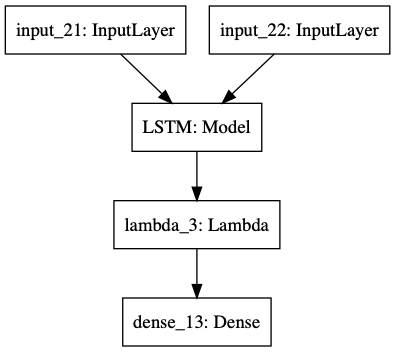

In [62]:
plot_model(siamese_LSTM)

In [63]:
siamese_LSTM.summary()

Model: "Siamese_LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 224, 224)     0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 224, 224)     0                                            
__________________________________________________________________________________________________
LSTM (Model)                    (None, 128)          616064      input_21[0][0]                   
                                                                 input_22[0][0]                   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128)          0           LSTM[1][0]            

# Train model

### 100 speakers. Epochs 0-5

Instructions for updating:
Use tf.cast instead.
Train on 9000 samples, validate on 900 samples
Epoch 1/5
9000/9000 [==============================] - 574s 64ms/step - loss: 0.6933 - acc: 0.4968 - val_loss: 0.6933 - val_acc: 0.4844

Epoch 00001: val_acc improved from -inf to 0.48444, saving model to siamese_LSTM.h5
Epoch 2/5
9000/9000 [==============================] - 8922s 991ms/step - loss: 0.6928 - acc: 0.5177 - val_loss: 0.6933 - val_acc: 0.4867

Epoch 00002: val_acc improved from 0.48444 to 0.48667, saving model to siamese_LSTM.h5
Epoch 3/5
9000/9000 [==============================] - 1432s 159ms/step - loss: 0.6926 - acc: 0.5231 - val_loss: 0.6930 - val_acc: 0.5133

Epoch 00003: val_acc improved from 0.48667 to 0.51333, saving model to siamese_LSTM.h5
Epoch 4/5
9000/9000 [==============================] - 528s 59ms/step - loss: 0.6924 - acc: 0.5266 - val_loss: 0.6933 - val_acc: 0.4967

Epoch 00004: val_acc did not improve from 0.51333
Epoch 5/5
9000/9000 [========================

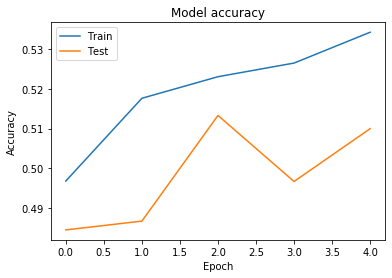

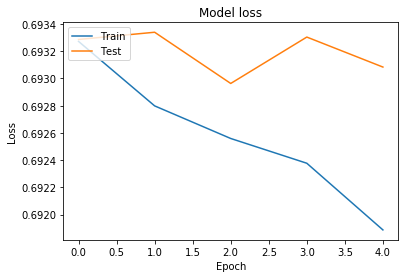

In [91]:
# Train and visualize 
checkpoint = ModelCheckpoint('siamese_LSTM.h5', 
                             monitor='val_acc', 
                             verbose=True,
                             save_best_only=True, 
                             mode='auto', 
                             period=1)

model = siamese_LSTM
history_siamese_LSTM = model.fit([X[:, 0], X[:, 1]], 
                                         y, 
                                         validation_data=([X_val[:, 0], X_val[:, 1]],
                                                          y_val), 
                                         epochs=5, 
                                         batch_size=32, 
                                         verbose=True,
                                         callbacks=[checkpoint])

# Plot training & validation accuracy values
plt.plot(history_siamese_LSTM.history['acc'])
plt.plot(history_siamese_LSTM.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history_siamese_LSTM.history['loss'])
plt.plot(history_siamese_LSTM.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

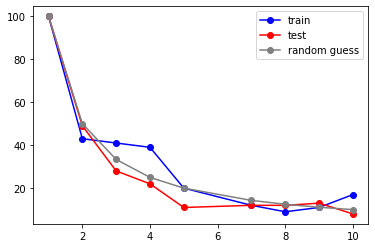

In [95]:
# One shot learning score:
model = siamese_LSTM
trials = 100
# n_way = 5
n_way_list = [1, 2, 3, 4, 5, 7, 8, 9, 10]
train_scores = []
test_scores = []
num_speakers = 10

random_scores = [100/i for i in n_way_list]

speaker_data_train = train_data_100
speaker_data_test = test_data_10

for n_way in n_way_list:
    one_shot_train = one_shot_learning.one_shot_score(model, trials, speaker_data_train, n_way)
    one_shot_test = one_shot_learning.one_shot_score(model, trials, speaker_data_test, n_way)
    
    train_scores.append(one_shot_train)
    test_scores.append(one_shot_test)

# Visualize one shot learning
plt.plot(n_way_list, train_scores, color='blue', marker='o', label='train')
plt.plot(n_way_list, test_scores, color='red', marker='o', label='test')
plt.plot(n_way_list, random_scores, color='gray', marker='o', label='random guess')

plt.legend()    

### 900 speakers. Epochs 

In [ ]:
# Adam optimizer
siamese_LSTM.compile(optimizer=Adam(lr = 0.001),
            loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# Train and visualize 
checkpoint = ModelCheckpoint('siamese_LSTM.h5', 
                             monitor='val_acc', 
                             verbose=True,
                             save_best_only=True, 
                             mode='auto', 
                             period=1)

model = siamese_LSTM
history_siamese_LSTM_2 = model.fit([X[:, 0], X[:, 1]], 
                                         y, 
                                         validation_data=([X_val[:, 0], X_val[:, 1]],
                                                          y_val), 
                                         epochs=5, 
                                         batch_size=32, 
                                         verbose=True,
                                         callbacks=[checkpoint])

# Plot training & validation accuracy values
plt.plot(history_siamese_LSTM_2.history['acc'])
plt.plot(history_siamese_LSTM_2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history_siamese_LSTM_2.history['loss'])
plt.plot(history_siamese_LSTM_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# One shot learning score:
model = siamese_LSTM
trials = 100
# n_way = 5
n_way_list = [1, 2, 3, 4, 5, 7, 8, 9, 10]
train_scores = []
test_scores = []
num_speakers = 10

random_scores = [100/i for i in n_way_list]

speaker_data_train = train_data_900
speaker_data_test = test_data_40

for n_way in n_way_list:
    one_shot_train = one_shot_learning.one_shot_score(model, trials, speaker_data_train, n_way)
    one_shot_test = one_shot_learning.one_shot_score(model, trials, speaker_data_test, n_way)
    
    train_scores.append(one_shot_train)
    test_scores.append(one_shot_test)

# Visualize one shot learning
plt.plot(n_way_list, train_scores, color='blue', marker='o', label='train')
plt.plot(n_way_list, test_scores, color='red', marker='o', label='test')
plt.plot(n_way_list, random_scores, color='gray', marker='o', label='random guess')

plt.legend()    

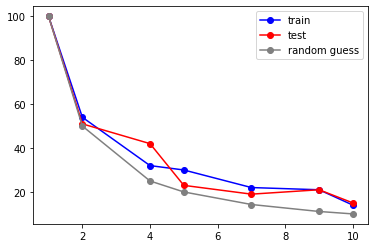

In [71]:
# One shot learning score:
model = siamese_MobileNetV2_s
trials = 100
# n_way = 5
n_way_list = [1, 2, 4, 5, 7, 9, 10]
train_scores = []
test_scores = []
num_speakers = 10

random_scores = [100/i for i in n_way_list]

speaker_data_train = data_10
speaker_data_test = test_data_40

for n_way in n_way_list:
    one_shot_train = one_shot_learning.one_shot_score(model, trials, speaker_data_train, n_way)
    one_shot_test = one_shot_learning.one_shot_score(model, trials, speaker_data_test, n_way)
    
    train_scores.append(one_shot_train)
    test_scores.append(one_shot_test)

# Visualize one shot learning
plt.plot(n_way_list, train_scores, color='blue', marker='o', label='train')
plt.plot(n_way_list, test_scores, color='red', marker='o', label='test')
plt.plot(n_way_list, random_scores, color='gray', marker='o', label='random guess')

plt.legend()    